# Logistic Regression

## Visualizing the data

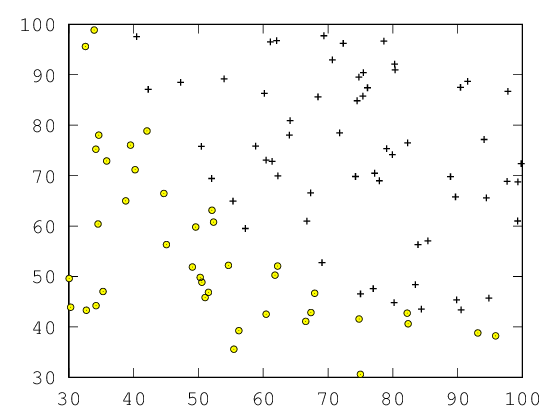

In [60]:
function plotData(X, y)
    pos = find(y == 1);
    neg = find(y == 0);

    plot(X(pos, 1), X(pos, 2), 'k+', 'LineWidth', 2, 'MarkerSize', 3);
    hold on;
    plot(X(neg, 1), X(neg, 2), 'ko', 'MarkerFaceColor', 'y', 'MarkerSize', 3);
endfunction

data = load('ex2data1.txt');
X = data(:, [1, 2]); y = data(:, 3);
plotData(X, y);

### sigmoid function

$$
\begin{eqnarray}
h_\theta(x)  & = & g(\theta^Tx)  \\
g(z) & = & {1 \over 1 + e^{-z}}
\end{eqnarray}
$$

ans =  0.50000


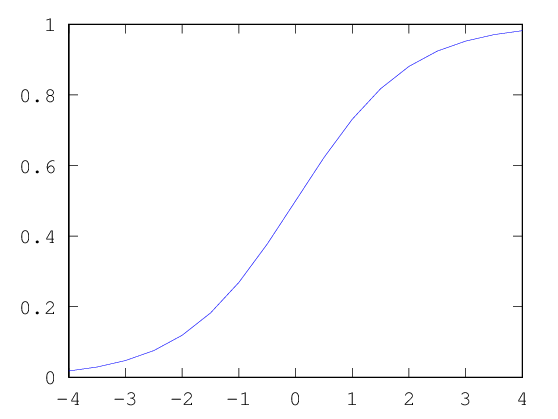

In [33]:
function g = sigmoid(z)
    es = ones(size(z)) * e;
    g = (es .^ (z * -1) + 1) .^ (-1);
endfunction

sigmoid(0)

x = -4:0.5:4;
y = sigmoid(x);
plot(x, y);

### Cost function

$$
J(\theta) = -{1 \over m}\sum_{i = 1}^m[
    y^{(i)}log(h_\theta(x^{(i)}))
    + (1 - y^{(i)})log(1 - h_\theta(x^{(i)}))
]
$$

### Gradient

$$
{\partial J(\theta) \over \partial \theta_j}
 = {1 \over m}\sum_{i = 1}^m(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}
$$

In [52]:
function [J, grad] = costFunction(theta, X, y)
    m = length(y);
    J = 0;
    grad = zeros(size(theta));
    
    for i = 1:m,
        g = sigmoid(theta' * X(i, :)');

        % compute cost
        J = J + (y(i) * log(g) + (1 - y(i)) * log(1 - g));
        % compute gradient
        grad = grad + X(i, :)' * (g - y(i));
    end;
    
    J = -1 * J / m;
    grad = grad / m;
endfunction

X = data(:, [1, 2]); y = data(:, 3);
[m, n] = size(X);

X = [ones(m, 1), X];
initial_theta = zeros(n + 1, 1);
[cost, grad] = costFunction(initial_theta, X, y)

cost =  0.69315
grad =

   -0.10000
  -12.00922
  -11.26284



### Learning parameters

ロジスティック回帰における最適なパラメータ $\theta$ を選択するのに Octave のビルトイン関数である　`fminunc` を使う。

In [55]:
options = optimset('GradObj', 'on', 'MaxIter', 400);
[theta, cost] = fminunc(@(t)(costFunction(t, X, y)), 
                                            initial_theta, options)

theta =

  -25.16127
    0.20623
    0.20147

cost =  0.20350


### Decision boundary

決定境界

$$
h_\theta(x) = g(\theta_0 + \theta_1x_1 + \theta_2x_2)
$$

としたとき $\theta_0 + \theta_1x_1 + \theta_2x_2 \ge 0$ ならば $y = 1$

つまり以下が決定境界

$$
\theta_0 + \theta_1x_1 + \theta_2x_2 = 0
$$

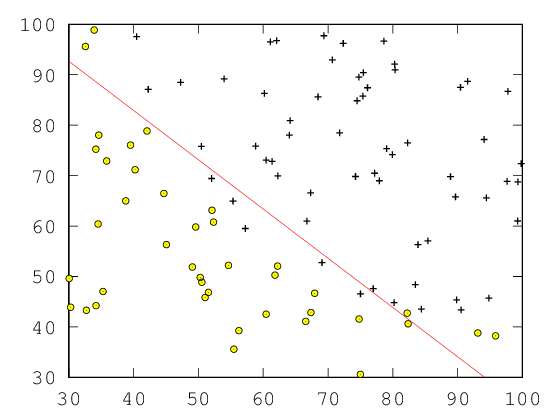

In [80]:
function plotDecisionBoundary(theta, X, y)
    plotData(X, y);
    
    plot_x = [min(X(:, 2)) - 10, max(X(:, 2)) + 10];
    plot_y = (plot_x * -1 * theta(3) .- theta(1)) ./ theta(2);
    
    plot(plot_x, plot_y, 'r');

    axis([30, 100, 30, 100]);
endfunction

plotDecisionBoundary(theta, X, y);